In [1]:
import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research')
from prelim_experiments.param_experiments.chaney_utils import (
    load_sim_results,
    graph_relative_to_ideal,
    merge_results,
    graph_metrics,
    graph_metrics_by_axis,
    graph_relative_to_global_by_axis,
    transform_relative_to_global,
    graph_histogram_metric_by_axis,
    graph_averaged_metric_by_axis
)
from wrapper.models.bubble import BubbleBurster
from src.utils import compute_constrained_clusters, create_global_user_pairs, user_topic_mapping, create_cluster_user_pairs, load_and_process_movielens, compute_embeddings
from wrapper.metrics.clustering_metrics import MeanCosineSim, MeanDistanceFromCentroid, MeanCosineSimPerCluster, MeanDistanceFromCentroidPerCluster
from param_experiments.chaney_utils import *

import warnings
warnings.simplefilter("ignore")

import itertools

In [2]:
DEBUG = True # don't save figures

In [3]:
import pprint

model_config = {
        'num_attributes': 10000,
        'num_items_per_iter': 10,
        'record_base_state': True,
        'probabilistic_recommendations':10000
    }

with open("test.txt", "w") as log_file:
        pprint.pprint('\nhello', log_file)
        pprint.pprint(model_config, log_file)
        pprint.pprint("byebye", log_file)
        pprint.pprint(model_config, log_file)

In [4]:
# results = merge_results(["param_exp_results/repeated_training", "param_exp_results/single_training"])

results_path = ["prelim_exp_results/10train90run", "prelim_exp_results/50train50run"]
results_file = ["sim_results.pkl", "sim_results.pkl"]
environment_file = ["sim_environment.pkl", "sim_environment.pkl"]
diagnostics_file = ["sim_diagnostics.pkl", "sim_diagnostics.pkl"]

results = merge_results(results_path, results_file)
print("# metrics =", len(results.keys()))
print(results.keys(), "\n")

# hyper_params = {
#     "drift":[0.05, 0.1], 
#     "attention_exp":[-0.2, -0.8], 
#     "repeated_training":[0, 1], 
#     "num_attrs":[15,20], 
#     "num_clusters":[15,20],
#     "compute_embeddings_via_surprise":[0],
#     "create_cluster_user_pairs_by_user_topic_mapping":[1]
# }

# model_params = dict()
# for p in itertools.product(*hyper_params.values()):
#     model_params[f"{p[0]}drift_{p[1]}attention_{p[2]}retraining_{p[3]}attributes_{p[4]}clusters_{p[5]}surprise_{p[6]}user-topic-mapping"] = dict(zip(hyper_params.keys(), p))

# model_keys = results['mse'].keys()
# print("# models =", len(model_keys))
# print(model_keys, "\n")

# id_to_readable = dict(zip(model_keys, [key[:-len("0surprise_1user-topic-mapping")-1] for key in model_keys]))
# print(id_to_readable)



# metrics = 14
dict_keys(['mse', 'interaction_spread', 'global_interaction_similarity', 'inter_cluster_interaction_similarity', 'intra_cluster_interaction_similarity', 'mean_global_cosine_sim', 'mean_intra_cluster_cosine_sim', 'mean_inter_cluster_cosine_sim', 'mean_cosine_sim_per_cluster', 'mean_cluster_distance_from_centroid', 'mean_global_distance_from_centroid', 'mean_distance_from_centroid_per_cluster', 'recall', 'rmse']) 

# models = 32
dict_keys(['0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping', '0.05drift_-0.2attention_1retraining_15attributes_20clusters_0surprise_1user-topic-mapping', '0.05drift_-0.2attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping', '0.05drift_-0.2attention_1retraining_20attributes_20clusters_0surprise_1user-topic-mapping', '0.05drift_-0.8attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping', '0.05drift_-0.8attention_1retraining_15attributes_20clusters_0surprise_1user-t

In [25]:
hyper_params = {
    "drift":[0.1], 
    "attention_exp":[-0.8], 
    "repeated_training":[0, 1], 
    "num_attrs":[20], 
    "num_clusters":[15],
    "compute_embeddings_via_surprise":[0],
    "create_cluster_user_pairs_by_user_topic_mapping":[1]
}

model_params = dict()
for p in itertools.product(*hyper_params.values()):
    model_params[f"{p[0]}drift_{p[1]}attention_{p[2]}retraining_{p[3]}attributes_{p[4]}clusters_{p[5]}surprise_{p[6]}user-topic-mapping"] = dict(zip(hyper_params.keys(), p))

model_keys = results['mse'].keys()
print("# models =", len(model_keys))
print(model_keys, "\n")

id_to_readable = dict(zip(model_keys, [key[:-len("0surprise_1user-topic-mapping")-1] for key in model_keys]))
print(id_to_readable)



# models = 32
dict_keys(['0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping', '0.05drift_-0.2attention_1retraining_15attributes_20clusters_0surprise_1user-topic-mapping', '0.05drift_-0.2attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping', '0.05drift_-0.2attention_1retraining_20attributes_20clusters_0surprise_1user-topic-mapping', '0.05drift_-0.8attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping', '0.05drift_-0.8attention_1retraining_15attributes_20clusters_0surprise_1user-topic-mapping', '0.05drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping', '0.05drift_-0.8attention_1retraining_20attributes_20clusters_0surprise_1user-topic-mapping', '0.1drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping', '0.1drift_-0.2attention_1retraining_15attributes_20clusters_0surprise_1user-topic-mapping', '0.1drift_-0.2attention_1retraining_20attribute

In [26]:
model_params

{'0.1drift_-0.8attention_0retraining_20attributes_15clusters_0surprise_1user-topic-mapping': {'drift': 0.1,
  'attention_exp': -0.8,
  'repeated_training': 0,
  'num_attrs': 20,
  'num_clusters': 15,
  'compute_embeddings_via_surprise': 0,
  'create_cluster_user_pairs_by_user_topic_mapping': 1},
 '0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping': {'drift': 0.1,
  'attention_exp': -0.8,
  'repeated_training': 1,
  'num_attrs': 20,
  'num_clusters': 15,
  'compute_embeddings_via_surprise': 0,
  'create_cluster_user_pairs_by_user_topic_mapping': 1}}

In [5]:
param_list = {
    "xquad_method":["smooth", "binary"],
    "alpha":[0.1, 0.25]
}
xquad_models = dict([(f"xquad_{p[0]}_{p[1]}alpha", p) for p in itertools.product(*param_list.values())])
xquad_models

{'xquad_smooth_0.1alpha': ('smooth', 0.1),
 'xquad_smooth_0.25alpha': ('smooth', 0.25),
 'xquad_binary_0.1alpha': ('binary', 0.1),
 'xquad_binary_0.25alpha': ('binary', 0.25)}

In [22]:
y_labels = dict([
    ("mse", "mse"), 
    ("interaction_spread", "interaction spread"), 
    ("global_interaction_similarity", "average jacard similarity"), 
    ("inter_cluster_interaction_similarity", "average jacard similarity"), 
    ("intra_cluster_interaction_similarity", "average jacard similarity"), 
    ("mean_global_cosine_sim", "average cosine sim"),
    ("mean_intra_cluster_cosine_sim", "average cosine sim"),
    ("mean_inter_cluster_cosine_sim", "average cosine sim"),
    ("mean_cosine_sim_per_cluster", "average cosine sim"),
    ("mean_cluster_distance_from_centroid", "distance"),
    ("mean_global_distance_from_centroid", "distance"),
    ("mean_distance_from_centroid_per_cluster", "distance"),
    ("interaction_measurement", "No. interactions per item"),
    ("recall", "recall"),
    ("rmse", "rmse")
])

# hyper_params = {
#     "drift":[0.05, 0.1], 
#     "attention_exp":[-0.2, -0.8], 
#     "repeated_training":[0, 1], 
#     "num_attrs":[15,20], 
#     "num_clusters":[15,20],
#     "compute_embeddings_via_surprise":[0],
#     "create_cluster_user_pairs_by_user_topic_mapping":[1]
# }

hyper_params = {
    "drift":[0.1], 
    "attention_exp":[-0.8], 
    "repeated_training":[0, 1], 
    "num_attrs":[20], 
    "num_clusters":[15],
    "compute_embeddings_via_surprise":[0],
    "create_cluster_user_pairs_by_user_topic_mapping":[1]
}

model_keys_grouped_by = {k: defaultdict(list) for k in hyper_params.keys()}
for model_name, param_dict in model_params.items():
    for param, value in param_dict.items():
        model_keys_grouped_by[param][value].append(model_name)

In [24]:
model_keys_grouped_by["repeated_training"]

defaultdict(list,
            {0: ['0.05drift_-0.2attention_0retraining_15attributes_15clusters_0surprise_1user-topic-mapping',
              '0.05drift_-0.2attention_0retraining_15attributes_20clusters_0surprise_1user-topic-mapping',
              '0.05drift_-0.2attention_0retraining_20attributes_15clusters_0surprise_1user-topic-mapping',
              '0.05drift_-0.2attention_0retraining_20attributes_20clusters_0surprise_1user-topic-mapping',
              '0.05drift_-0.8attention_0retraining_15attributes_15clusters_0surprise_1user-topic-mapping',
              '0.05drift_-0.8attention_0retraining_15attributes_20clusters_0surprise_1user-topic-mapping',
              '0.05drift_-0.8attention_0retraining_20attributes_15clusters_0surprise_1user-topic-mapping',
              '0.05drift_-0.8attention_0retraining_20attributes_20clusters_0surprise_1user-topic-mapping',
              '0.1drift_-0.2attention_0retraining_15attributes_15clusters_0surprise_1user-topic-mapping',
              '0.

In [8]:
def graph_averaged_metric_by_axis(ax, train_results, metric_key, model_keys, label_map, mean_sigma=0, mult_sd=0, conf_sigma=0, graph_by="params", mean_range=10, print_num_vals=0, legend=0):
    values = None
    for m in model_keys:
        # print(m)
        if not isinstance(train_results[metric_key][m], np.ndarray):
            train_results[metric_key][m] = np.array(train_results[metric_key][m])
        if values is None:
            values = train_results[metric_key][m]
        else:
            values = np.vstack((values, train_results[metric_key][m]))
    mean_values = values.mean(axis=0)
    
    print(metric_key, "{0:.5f}".format(mean_values[-1:-mean_range:-1].mean()))
    if print_num_vals:
        print(mean_values[-1:-mean_range:-1])
        
    if legend:
        ax.plot(mean_values, label=metric_key)
        # ax.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5))
    else:
        ax.plot(mean_values)
    return ax

In [9]:
# Which hyper-param to graph by
graph_by_hyper_param = "repeated_training"
# graph_by_hyper_param = "drift"
# graph_by_hyper_param = "attention_exp"
# graph_by_hyper_param = "num_attrs"
# graph_by_hyper_param = "num_clusters"

metric_key = "mse"
# metric_key = "interaction_spread"
# metric_key = "recall"
# metric_key = "rmse"

variables = (graph_by_hyper_param, metric_key)

In [ ]:
metric_key = "mse"

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

graph_metrics_by_axis(axs[0], results, metric_key, model_keys_by_training["single_training"], id_to_readable_single_training, mult_sd=0)
axs[0].set_ylabel(y_labels[metric_key])
axs[0].set_xlabel("Timestep")
axs[0].set_title(f"{metric_key}, single training")
axs[0].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, -0.15), fontsize="8",)

graph_metrics_by_axis(axs[1], repeated_training_results, metric_key, model_keys_by_training["repeated_training"], id_to_readable_repeated_training, mult_sd=0)
axs[1].set_ylabel(y_labels[metric_key])
axs[1].set_xlabel("Timestep")
axs[1].set_title(f"{metric_key}, repeated training")
axs[1].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, -0.15), fontsize="8",)

[0, 1]


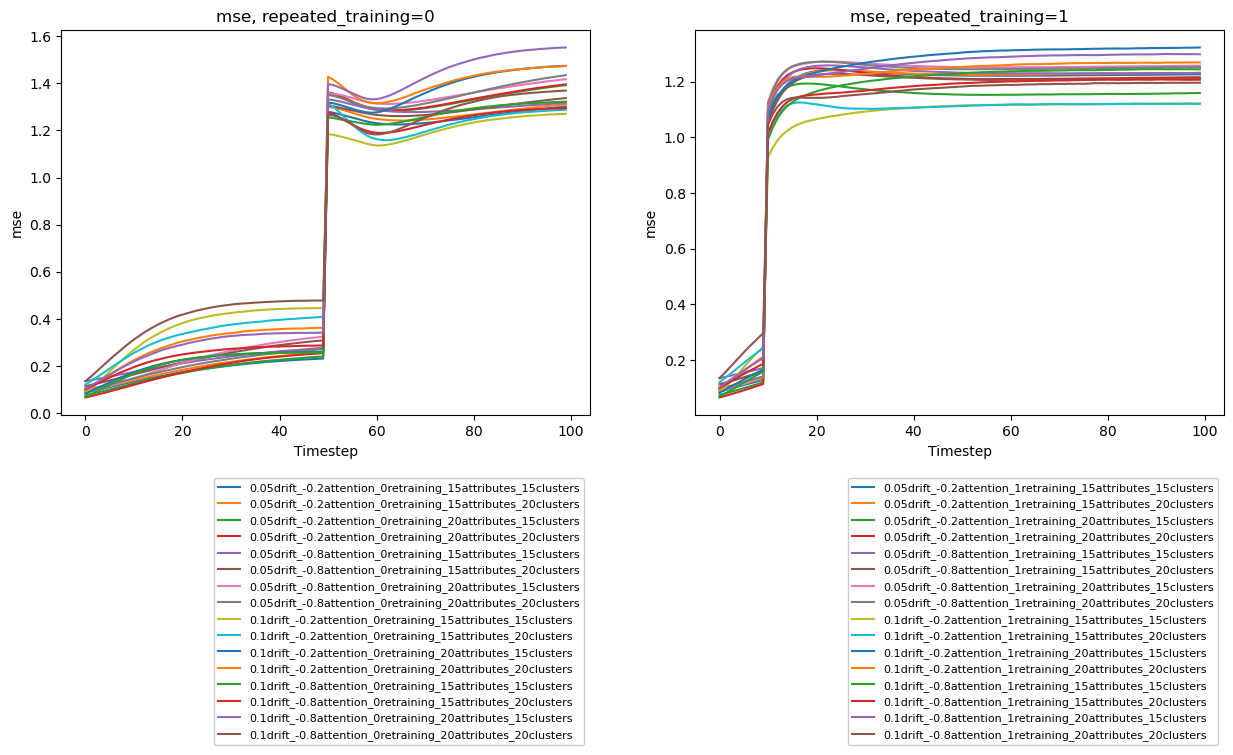

In [16]:
hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])
print(hyper_param_values)
num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    graph_metrics_by_axis(axs[i], results, metric_key, model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"{metric_key}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, -0.15), fontsize="8",)


repeated_training=0
mse 1.31108

repeated_training=1
mse 1.21898


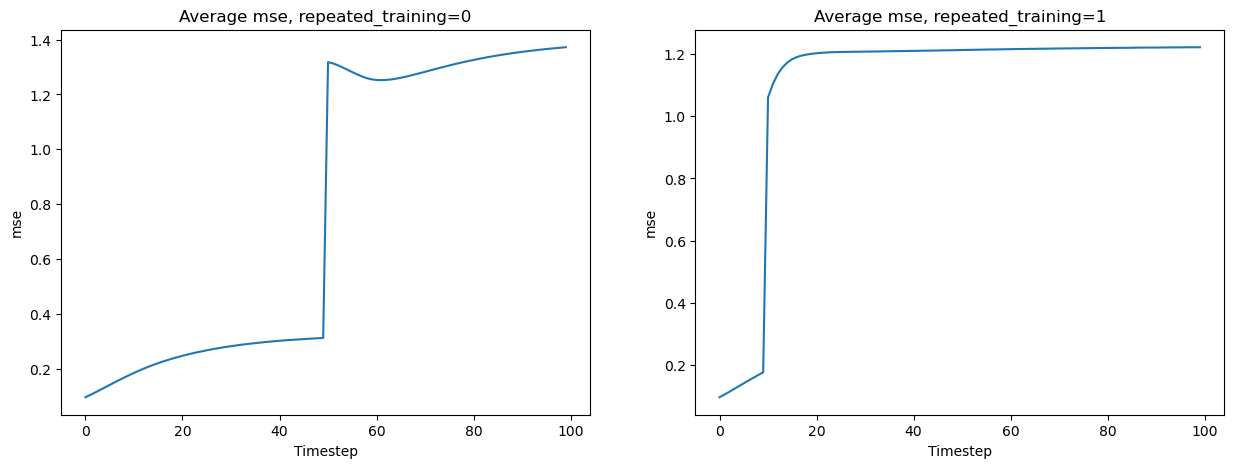

In [11]:
# Which hyper-param to graph by
# graph_by_hyper_param = "drift"
# metric_key = "mse"

hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_key, model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, mean_range=50)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {metric_key}, {graph_by_hyper_param}={param_val}")

## `Cosine similarity`


repeated_training=0
mean_intra_cluster_cosine_sim 0.54937
mean_global_cosine_sim 0.54953
mean_inter_cluster_cosine_sim 0.54433

repeated_training=1
mean_intra_cluster_cosine_sim 0.81774
mean_global_cosine_sim 0.81800
mean_inter_cluster_cosine_sim 0.80838

diff= 0.01625
normalized diff= 0.02390

diff= -0.00186
normalized diff= -0.00271


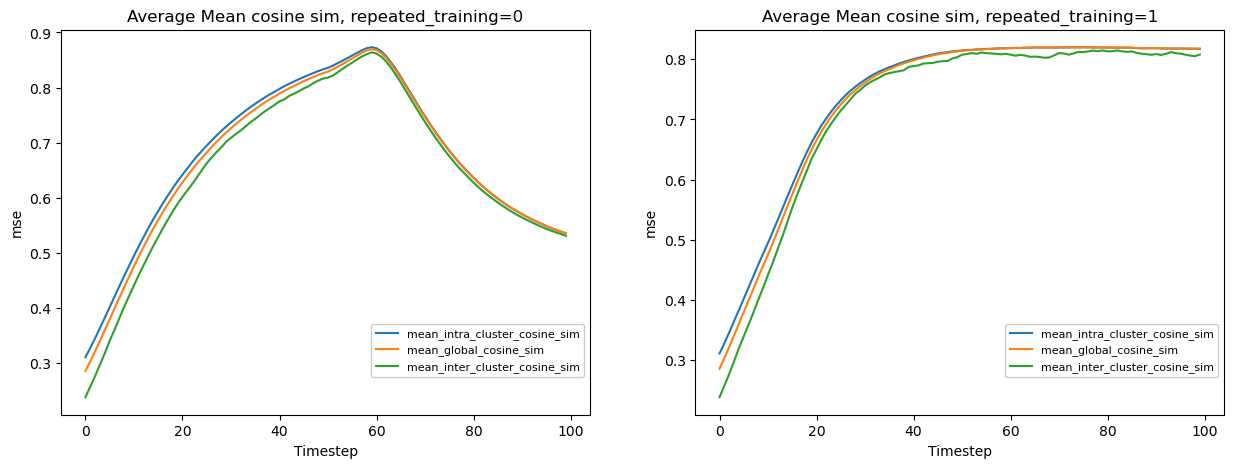

In [12]:
title = "Mean cosine sim"
metric_keys = ["mean_intra_cluster_cosine_sim", "mean_global_cosine_sim", "mean_inter_cluster_cosine_sim"]

hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[0], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[1], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[2], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {title}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)

print()
a1 = 0.67988
a2 = 0.66363
print("diff=", "{0:.5f}".format(a1-a2))
print("normalized diff=", "{0:.5f}".format((a1-a2)/a1))

print()
b1 = 0.68722
b2 = 0.68908
print("diff=", "{0:.5f}".format(b1-b2))
print("normalized diff=", "{0:.5f}".format((b1-b2)/b1))

## `Interaction similarity`


repeated_training=0
intra_cluster_interaction_similarity 0.05702
global_interaction_similarity 0.05630
inter_cluster_interaction_similarity 0.05512

repeated_training=1
intra_cluster_interaction_similarity 0.03625
global_interaction_similarity 0.03612
inter_cluster_interaction_similarity 0.03579

diff= 0.00138
normalized diff= 0.02897

diff= 0.00097
normalized diff= 0.02126


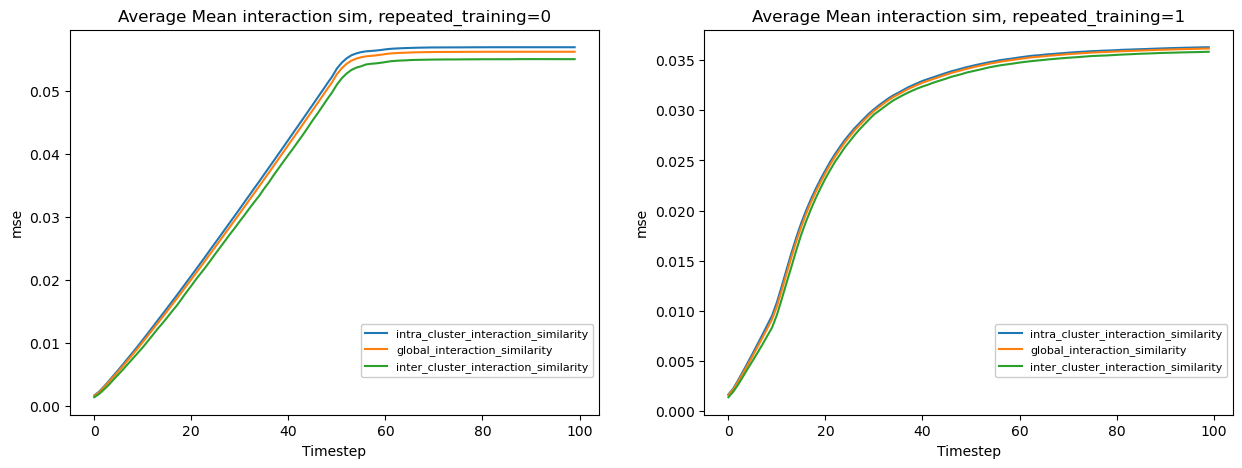

In [13]:
title = "Mean interaction sim"
metric_keys = ["intra_cluster_interaction_similarity", "global_interaction_similarity", "inter_cluster_interaction_similarity"]

hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[0], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[1], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[2], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {title}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)
    
print()
a1 = 0.04763
a2 = 0.04625
print("diff=", "{0:.5f}".format(a1-a2))
print("normalized diff=", "{0:.5f}".format((a1-a2)/a1))

print()
b1 = 0.04563
b2 = 0.04466
print("diff=", "{0:.5f}".format(b1-b2))
print("normalized diff=", "{0:.5f}".format((b1-b2)/b1))

In [ ]:
def graph_metrics_difference_by_axis(ax, train_results, larger_metric, smaller_metric, model_keys, label_map, mean_sigma=0, mult_sd=0, conf_sigma=0, normalized=True, label=""):
    for m in model_keys:
        if not isinstance(train_results[metric_key][m], np.ndarray):
            train_results[metric_key][m] = np.array(train_results[metric_key][m])
        # average across trials and smooth, if necessary
        larger_values = np.array(train_results[larger_metric][m])
        smaller_values = np.array(train_results[smaller_metric][m])
        difference = larger_values - smaller_values
        if normalized:
            difference = np.divide(difference, larger_values)
        if mean_sigma > 0:
            values = gaussian_filter1d(difference.mean(axis=0), sigma=mean_sigma)
        else:
            values = difference.mean(axis=0)
        
        if label == "by_params":
            line_label = label_map[m]
        elif label == "by_metric":
            line_label = metric_key
        else:
            line_label = label
        line = ax.plot(values, label=line_label)
        line_color = line[0].get_color()
        if mult_sd > 0:
            std = train_results[metric_key][m].std(axis=0)
            timesteps = np.arange(len(std))
            low = values - mult_sd * std
            high = values + mult_sd * std
            if conf_sigma > 0:
                low = gaussian_filter1d(low, sigma=conf_sigma)
                high = gaussian_filter1d(high, sigma=conf_sigma)
            ax.fill_between(timesteps, low, high, color = line_color, alpha=0.3)
    ax.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.5))
    return ax

## `Centroid distance`


repeated_training=0
mean_global_distance_from_centroid 1.06049
mean_cluster_distance_from_centroid 0.76060

repeated_training=1
mean_global_distance_from_centroid 1.00342
mean_cluster_distance_from_centroid 0.72686

diff= 0.30965
normalized diff= 0.28978

diff= 0.26680
normalized diff= 0.26805


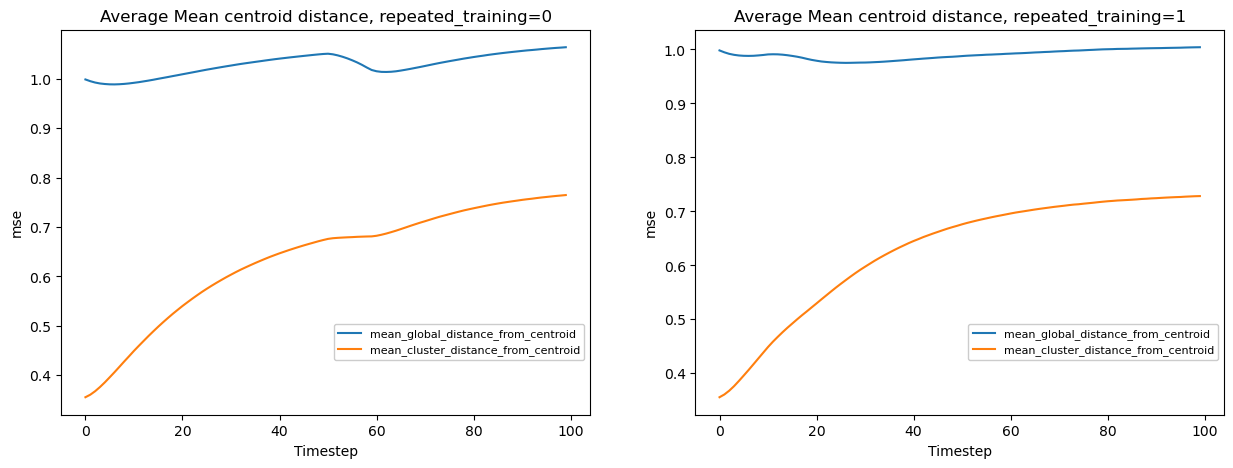

In [14]:
title = "Mean centroid distance"
metric_keys = ["mean_global_distance_from_centroid", "mean_cluster_distance_from_centroid"]

hyper_param_values = list(model_keys_grouped_by[graph_by_hyper_param])

num_plots = len(hyper_param_values)
fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

for i, param_val in enumerate(hyper_param_values):
    print(f"\n{graph_by_hyper_param}={param_val}")
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[0], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    graph_averaged_metric_by_axis(axs[i], results, metric_keys[1], model_keys_grouped_by[graph_by_hyper_param][param_val], id_to_readable, mult_sd=0, legend=1)
    axs[i].set_ylabel(y_labels[metric_key])
    axs[i].set_xlabel("Timestep")
    axs[i].set_title(f"Average {title}, {graph_by_hyper_param}={param_val}")
    axs[i].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, 0.25), fontsize="8",)

print()
a1 = 1.06857
a2 = 0.75892
print("diff=", "{0:.5f}".format(a1-a2))
print("normalized diff=", "{0:.5f}".format((a1-a2)/a1))

print()
b1 = 0.99534
b2 = 0.72854
print("diff=", "{0:.5f}".format(b1-b2))
print("normalized diff=", "{0:.5f}".format((b1-b2)/b1))

In [15]:
# print(results.keys())
# # results["mean_distance_from_centroid_per_cluster"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"]
# test_results["mean_distance_from_centroid_per_cluster"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"]

dict_keys(['mse', 'interaction_spread', 'global_interaction_similarity', 'inter_cluster_interaction_similarity', 'intra_cluster_interaction_similarity', 'mean_global_cosine_sim', 'mean_intra_cluster_cosine_sim', 'mean_inter_cluster_cosine_sim', 'mean_cosine_sim_per_cluster', 'mean_cluster_distance_from_centroid', 'mean_global_distance_from_centroid', 'mean_distance_from_centroid_per_cluster', 'recall', 'rmse'])


NameError: name 'test_results' is not defined

### Checking `InteractionMeasurement`

In [ ]:
# results = merge_results(["param_exp_results/repeated_training", "param_exp_results/single_training"])

test_results_path = ["prelim_exp_results/test_interaction_measurement"]
results_file = ["sim_results.pkl"]

test_results = merge_results(test_results_path, results_file)
print("# metrics =", len(test_results.keys()))
print(test_results.keys(), "\n")

test_results["interaction_measurement"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"]##'0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping'

# metrics = 15
dict_keys(['mse', 'interaction_spread', 'global_interaction_similarity', 'inter_cluster_interaction_similarity', 'intra_cluster_interaction_similarity', 'mean_global_cosine_sim', 'mean_intra_cluster_cosine_sim', 'mean_inter_cluster_cosine_sim', 'mean_cosine_sim_per_cluster', 'mean_cluster_distance_from_centroid', 'mean_global_distance_from_centroid', 'mean_distance_from_centroid_per_cluster', 'interaction_measurement', 'recall', 'rmse']) 



[[array([0., 0., 1., ..., 0., 0., 0.]),
  array([4., 0., 0., ..., 0., 0., 0.]),
  array([5., 1., 1., ..., 0., 0., 0.]),
  array([2., 0., 0., ..., 0., 0., 0.]),
  array([2., 1., 0., ..., 0., 0., 0.]),
  array([5., 0., 0., ..., 0., 0., 0.]),
  array([5., 0., 0., ..., 0., 0., 0.]),
  array([7., 0., 0., ..., 0., 0., 0.]),
  array([4., 0., 1., ..., 0., 0., 0.]),
  array([4., 1., 0., ..., 0., 0., 0.]),
  array([3., 0., 0., ..., 0., 0., 0.]),
  array([3., 0., 0., ..., 1., 0., 0.]),
  array([3., 1., 0., ..., 0., 1., 0.]),
  array([2., 0., 0., ..., 0., 0., 0.]),
  array([1., 0., 0., ..., 0., 1., 0.])]]

## Checking `environment` variable results

In [ ]:
# results = merge_results(["param_exp_results/repeated_training", "param_exp_results/single_training"])

results_path = ["prelim_exp_results/10train90run", "prelim_exp_results/50train50run"]
environment_file = ["sim_environment.pkl", "sim_environment.pkl"]

environments = merge_results(results_path, environment_file)

In [ ]:
environments.keys()

dict_keys(['actual_user_representation_initial', 'actual_user_representation_final', 'user_cluster_assignments', 'user_cluster_centroids', 'item_representation', 'item_cluster_assignments', 'item_cluster_centroids', 'global_user_centroid', 'user_item_cluster_mapping'])

In [ ]:
user_representation = environments["actual_user_representation_initial"]["0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping"][0]
item_cluster_centers = environments["item_cluster_centroids"]["0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping"][0]
user_item_cluster_mapping = user_topic_mapping(user_representation, item_cluster_centers)
# inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_item_cluster_mapping)

In [ ]:
print(user_item_cluster_mapping.shape)
print(user_item_cluster_mapping[:15])
sim_mapping = environments["user_item_cluster_mapping"]["0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping"][0]
print(sim_mapping.shape)
print(sim_mapping[:15])
np.array_equal(user_item_cluster_mapping, sim_mapping)

(943,)
[0 8 8 8 8 7 7 8 8 0 8 8 0 8 8]
(943,)
[0 8 8 8 8 7 7 8 8 0 8 8 0 8 8]


True

In [ ]:
final_user_representation = environments["actual_user_representation_final"]["0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping"][0]
item_cluster_centers = environments["item_cluster_centroids"]["0.05drift_-0.2attention_1retraining_15attributes_15clusters_0surprise_1user-topic-mapping"][0]
final_user_item_cluster_mapping = user_topic_mapping(final_user_representation, item_cluster_centers)
print(final_user_item_cluster_mapping.shape)
print(final_user_item_cluster_mapping[:15])

(943,)
[ 0  8  8  8  0 11 11  8  8  8 11  8  4  8  8]


## Checking `diagnostics` results

In [ ]:
# results = merge_results(["param_exp_results/repeated_training", "param_exp_results/single_training"])

# test_results_path = ["prelim_exp_results/test_interaction_measurement"]
test_results_path = ["/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research/sim_experiments/sim_results/tester"]
diagnostics_file = ["sim_diagnostics.pkl"]

# diagnostics = load_sim_results(test_results_path[0], diagnostics_file[0])
diagnostics = merge_results(test_results_path, diagnostics_file)
diagnostics

defaultdict(<function param_experiments.chaney_utils.merge_results.<locals>.<lambda>()>,
            {'mean_cluster_distance_from_centroid': defaultdict(list,
                         {'0.1drift_-0.8attention_1retraining_20attributes_15clusters_1user-topic-mapping': ['mean',
                           'std',
                           'median',
                           'min',
                           'max',
                           'skew']}),
             'global_interaction_similarity': defaultdict(list,
                         {'0.1drift_-0.8attention_1retraining_20attributes_15clusters_1user-topic-mapping': ['mean',
                           'std',
                           'median',
                           'min',
                           'max',
                           'skew']}),
             'mean_inter_cluster_cosine_sim': defaultdict(list,
                         {'0.1drift_-0.8attention_1retraining_20attributes_15clusters_1user-topic-mapping': ['mean',
        

In [ ]:
print(diagnostics.keys())
print(diagnostics["mean_global_cosine_sim"].keys())
print(diagnostics["mean_global_cosine_sim"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"].keys())
print(diagnostics["mean_global_cosine_sim"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"]["max"])

dict_keys(['mean_global_cosine_sim', 'global_interaction_similarity', 'mse', 'intra_cluster_interaction_similarity', 'mean_cosine_sim_per_cluster', 'mean_novelty', 'inter_cluster_interaction_similarity', 'mean_intra_cluster_cosine_sim', 'mean_inter_cluster_cosine_sim', 'mean_cluster_distance_from_centroid', 'mean_global_distance_from_centroid'])
dict_keys(['0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping'])
dict_keys(['mean', 'std', 'median', 'min', 'max', 'skew'])
[array([1.        , 0.99834055, 0.99844143, 0.9948798 , 0.99416018,
       0.99203462, 0.98681001, 0.9857556 , 0.98252948, 0.98143327,
       0.98387709, 0.97777761, 0.9799723 , 0.97888591, 0.97622648,
       0.98099546])]


In [ ]:
# results = merge_results(["param_exp_results/repeated_training", "param_exp_results/single_training"])

test_results_path = ["prelim_exp_results/test_interaction_measurement"]
test_results_file = ["sim_results.pkl"]

test_results = load_sim_results(test_results_path[0], test_results_file[0])

print(test_results.keys())
print(test_results["mean_global_cosine_sim"].keys())
print(test_results["mean_global_cosine_sim"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"])
# print(test_results["mean_global_cosine_sim"]["0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping"]["mean"])

dict_keys(['mse', 'interaction_spread', 'global_interaction_similarity', 'inter_cluster_interaction_similarity', 'intra_cluster_interaction_similarity', 'mean_global_cosine_sim', 'mean_intra_cluster_cosine_sim', 'mean_inter_cluster_cosine_sim', 'mean_cosine_sim_per_cluster', 'mean_cluster_distance_from_centroid', 'mean_global_distance_from_centroid', 'mean_distance_from_centroid_per_cluster', 'interaction_measurement', 'recall', 'rmse', 'mean_novelty'])
dict_keys(['0.1drift_-0.8attention_1retraining_20attributes_15clusters_0surprise_1user-topic-mapping'])
[[0.26770401468208144, 0.2912790811183744, 0.3152563364891144, 0.3397889095070587, 0.36446276222519236, 0.38909356427299746, 0.4137040243383244, 0.4393738330752117, 0.46610463893552434, 0.49524089380560254, 0.5224004609770745, 0.5501557385578394, 0.5764106652710735, 0.6025538006681723, 0.6272349937100522]]


In [ ]:
drift=0.1
attention_exp=-0.8
num_attrs=20
num_clusters=15